In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

SEED = 322

Firstly, we download data and resample wavs into 16 kGz:

In [6]:
from src.utils.preprocessing import resample_data

!git clone https://github.com/soerenab/AudioMNIST.git

AudioMNIST_dir = "AudioMNIST/data"
new_dir = "data/wavs"
new_sample_rate = 16_000

resample_data(AudioMNIST_dir, new_dir, new_sample_rate)
!rm -rf AudioMNIST

In [7]:
!du -hs data

1.3G	data


As all the recordings take only 1.3G, there is no problem to store them all in memory. Now, split all speakers into train and test groups (2:1):

In [ ]:
speaker_ids = np.array(os.listdir(new_dir))

test_speakers = np.random.choice(speaker_ids, int(len(speaker_ids) // 3), False)
train_val_speakers = np.array([idx for idx in speaker_ids if idx not in test_speakers])

And construct DataFrame with path, speaker id and digit for each wav:

In [10]:
from src.utils.preprocessing import form_df

train_val_df = form_df(train_val_speakers, new_dir)
train_val_df = train_val_df.sample(frac=1, random_state=SEED)  # shuffle
train_val_df.head()

,paths,speaker,y
6128,data/wavs/20/5_20_4.wav,20,5
7451,data/wavs/47/3_47_45.wav,47,3
8784,data/wavs/28/2_28_33.wav,28,2
18191,data/wavs/37/0_37_3.wav,37,0
12505,data/wavs/49/4_49_21.wav,49,4


### Stratified split

Now we perform stratified split of train data into train and validation groups by speaker and digit.

In [11]:
groups = train_val_df.groupby(by=["speaker", "y"])
train_split = 0.8

train_ids = np.array([])
val_ids = np.array([])
for i, group in groups:
    group_train_ids, group_val_ids = np.split(group.index, [int(len(group) * train_split)])
    train_ids = np.append(train_ids, group_train_ids)
    val_ids = np.append(val_ids, group_val_ids)

train_df = train_val_df.iloc[train_ids]
val_df = train_val_df.iloc[val_ids]

In [12]:
# Shapes

print(train_val_df.shape)
print(train_df.shape)
print(val_df.shape)

(20000, 3)
(16000, 3)
(4000, 3)


In [17]:
# target distribution

train_df["y"].value_counts().sort_index() / train_df.shape[0]

0    0.100562
1    0.099812
2    0.098937
3    0.101125
4    0.100000
5    0.099687
6    0.101500
7    0.099687
8    0.099562
9    0.099125
Name: y, dtype: float64

# speakers distribution

train_df["speaker"].value_counts().sort_index() / train_df.shape[0]

### Supervised learning

We train our 1D and 2D encoders supervisely on train data.

In [ ]:
# 1D encoder supervised train
!python3 supervised.py --type 1d --num_epochs 10 --log_steps 50
#wandb logs: https://wandb.ai/johan_ddc_team/ssl_hw4/runs/y0vai29t?workspace=user-johan_ddc

![](../misc/audio/1d.jpg)

In [ ]:
# 2D encoder supervised train
!python3 supervised.py --type 2d --num_epochs 10 --log_steps 50
# wandb logs: https://wandb.ai/johan_ddc_team/ssl_hw4/runs/3pfpqpay?workspace=user-johan_ddc

![](../misc/audio/2d.jpg)

So, for 1D encoder we obtained 98.4% accuracy, and for 2D 99.2% accuracy.

### Multi-format contrastive learning

Here we apply pretrain approach described in paper [Multi-format contrastive learning](https://arxiv.org/abs/2103.06508). For each recording authors use two random clips of 3 seconds length. But all our recordings last less than 1 second, so we firstly sweep over different (relative) clip lengths.

Possible lengths are 30%, 40% 50% (with no gap) and 60% (with overlapping clips). Models with 40% and 50% of recording length showed the best quality, so latter we will use clip length of 45%.

In [3]:
from src.data.collate import crop_collator
from torch.utils.data import DataLoader
from src.utils.utils import set_random_seed
from pretrain import get_dataloaders

set_random_seed(SEED)

data_dir = "data/wavs"
batch_size = 104
num_workers = 6
device = "cuda"


def loaders_with_croplen(crop_len, overlap=False):
    train_dataloader, test_dataloader = get_dataloaders(data_dir)

    train_dataloader = DataLoader(train_dataloader.dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers,
                                  collate_fn=lambda batch: crop_collator(batch, ratio=crop_len, overlap=overlap),
                                  pin_memory=True, drop_last=True)
    test_dataloader = DataLoader(test_dataloader.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                                 collate_fn=lambda batch: crop_collator(batch, ratio=crop_len, overlap=overlap),
                                 pin_memory=True, drop_last=True)
    return train_dataloader, test_dataloader

In [4]:
import wandb
from torch.optim.lr_scheduler import CosineAnnealingLR
from src.model.MFCL.loss import ContrastiveLoss
from src.model.MFCL.MFCL import MFCL
from pretrain import get_augmentations, train_one_epoch, evaluate

num_epochs = 10

train_dataloader, test_dataloader = loaders_with_croplen(crop_len=0.45, overlap=False)
transforms = get_augmentations("mel")
model = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
             hop_length=160, n_mels=80)
criterion = ContrastiveLoss(temperature=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, num_epochs * len(train_dataloader) + 2, 1e-6)

model.to(device)
os.makedirs(f"checkpoints/mfcl/", exist_ok=True)

with wandb.init(job_type="supervised", dir="wandb_logs", project="ssl_hw4", entity="johan_ddc_team",
                name=f"MFCL_mel_augs"):
    for i in range(1, num_epochs + 1):
        epoch_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device, scheduler=scheduler)
        val_loss = evaluate(model, test_dataloader, criterion, device)

        wandb.log({
            "epoch_loss": epoch_loss.item(),
            "test_loss": val_loss.item(),
        })
    torch.save(model.state_dict(), f"checkpoints/mfcl/mel.pth")

In [6]:
import supervised

train_dataloader, val_dataloader, test_dataloader = supervised.get_dataloaders(data_dir)
criterion = nn.CrossEntropyLoss()
model = supervised.load_model("mel")

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-3, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, num_epochs * len(train_dataloader) + 2, 1e-6)

model.to(device)
os.makedirs(f"checkpoints/2d_mel/", exist_ok=True)
best = [None, 0]
with wandb.init(job_type="supervised", dir="wandb_logs", project="ssl_hw4", entity="johan_ddc_team",
                name=f"probing_2d_mel"):
    for i in range(1, num_epochs + 1):
        epoch_loss = supervised.train_one_epoch(model, train_dataloader, criterion, optimizer, device,
                                                scheduler=scheduler)
        val_loss, val_acc = supervised.evaluate(model, test_dataloader, criterion, device)

        wandb.log({
            "epoch_loss": epoch_loss.item(),
            "test_loss": val_loss.item(),
            "accuracy": val_acc.item()
        })

        if best[0] is None or val_acc > best[1]:
            best = [model.state_dict(), val_acc]
    torch.save(best[0], f"checkpoints/2d_mel/final_model.pth")

## Visualization

Here we plot TSNE embeddings for 1D and 2D encoders, which were trained supervisely on digit classification task and self-supervisely by MFCL approach.

### 1D encoder supervised

In [5]:
from src.model.Encoder1D import Encoder1D


@torch.no_grad()
def get_embeddings(model, loader):
    speakers = []
    digits = []
    embeddings = []
    for batch in loader:
        embs = model(batch["wav"].to(device, non_blocking=True))

        embeddings.extend(embs.cpu().numpy())
        speakers.extend(batch["speaker"].numpy())
        digits.extend(batch["target"].numpy())

    speakers = np.array(speakers)
    digits = np.array(digits)
    embeddings = np.array(embeddings)
    return embeddings, speakers, digits

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.colors as col


def draw_tsne(embeddings, speakers, digits):
    tsne = TSNE(metric="cosine", n_jobs=8)
    tsne_embeddings = tsne.fit_transform(embeddings)

    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set(title="TSNE digits")
    ax[1].set(title="TSNE speakers")

    for digit in range(10):
        ax[0].scatter(tsne_embeddings[digits == digit, 0],
                      tsne_embeddings[digits == digit, 1],
                      c=f"C{digit}", label=f"{digit}")

    speaker_colors = cm.rainbow(np.linspace(0, 1, len(np.unique(speakers))))
    speaker_colors = [col.to_hex(x, keep_alpha=False) for x in speaker_colors]
    for idx, speaker in enumerate(np.unique(speakers)):
        ax[1].scatter(tsne_embeddings[speakers == speaker, 0],
                      tsne_embeddings[speakers == speaker, 1],
                      c=f"{speaker_colors[idx]}", label=f"{speaker}")

    ax[0].legend()
    ax[1].legend()
    plt.show()

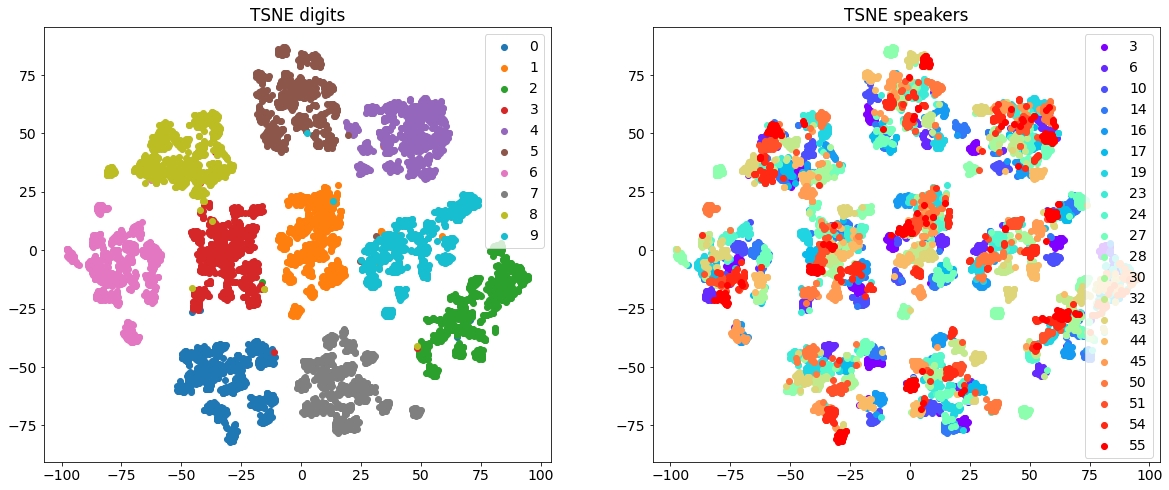

In [9]:
import supervised

data_dir = "data/wavs"
batch_size = 104
num_workers = 6
device = "cuda"

model = nn.Sequential(
    Encoder1D(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("checkpoints/1d/final_model.pth"))
model = model[0]
model.to(device)
_, _, test_dataloader = supervised.get_dataloaders(data_dir)

embeddings, speakers, digits = get_embeddings(model, test_dataloader)
draw_tsne(embeddings, speakers, digits)

### 1D encoder self-supervised

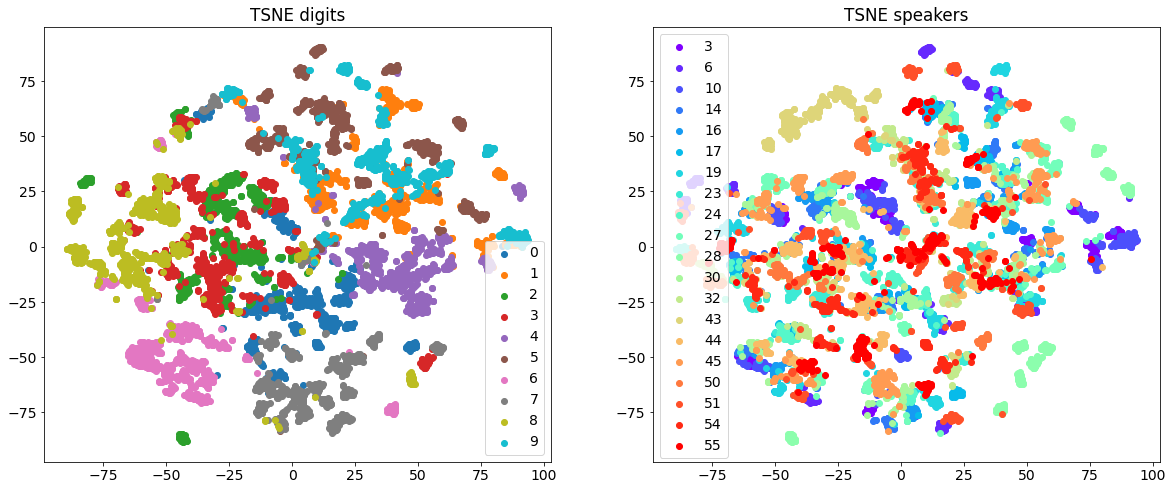

In [10]:
from pretrain import get_augmentations
from src.model.MFCL.MFCL import MFCL

transforms = get_augmentations("no")
mdl = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
           hop_length=160, n_mels=80)
mdl.load_state_dict(torch.load(f"checkpoints/mfcl/no.pth"))
model = mdl.wav_encoder
model.to(device)
_, _, test_dataloader = supervised.get_dataloaders(data_dir)

embeddings, speakers, digits = get_embeddings(model, test_dataloader)
draw_tsne(embeddings, speakers, digits)

### 2D encoder supervised

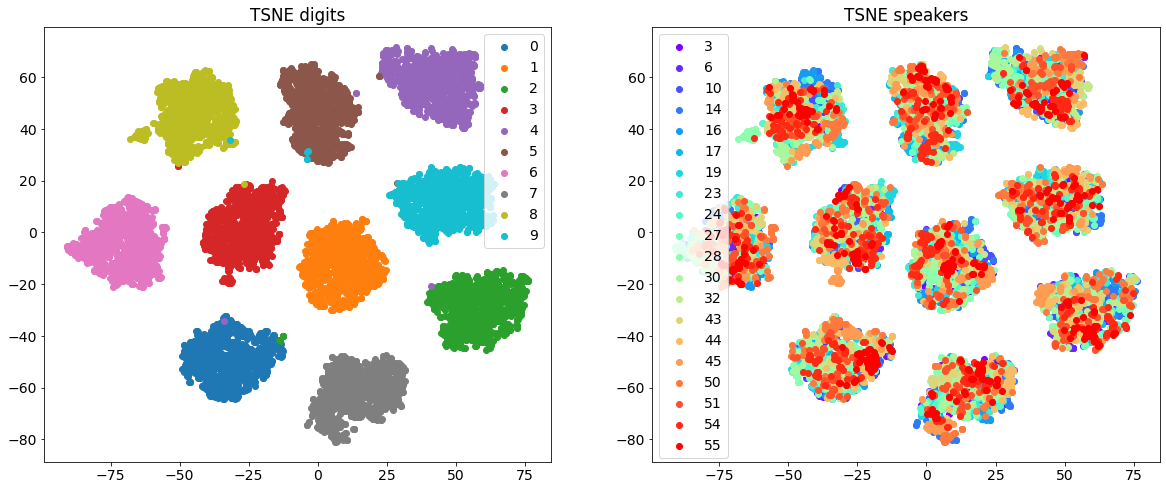

In [11]:
from src.utils.LogMelSpec import LogMelSpec
from src.model.Encoder2D import Encoder2D

model = nn.Sequential(
    LogMelSpec(min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
               hop_length=160, n_mels=80),
    Encoder2D(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("checkpoints/2d/final_model.pth"))
model = nn.Sequential(model[0], model[1])
model.to(device)
_, _, test_dataloader = supervised.get_dataloaders(data_dir)

embeddings, speakers, digits = get_embeddings(model, test_dataloader)
draw_tsne(embeddings, speakers, digits)

### 2D encoder self-supervised

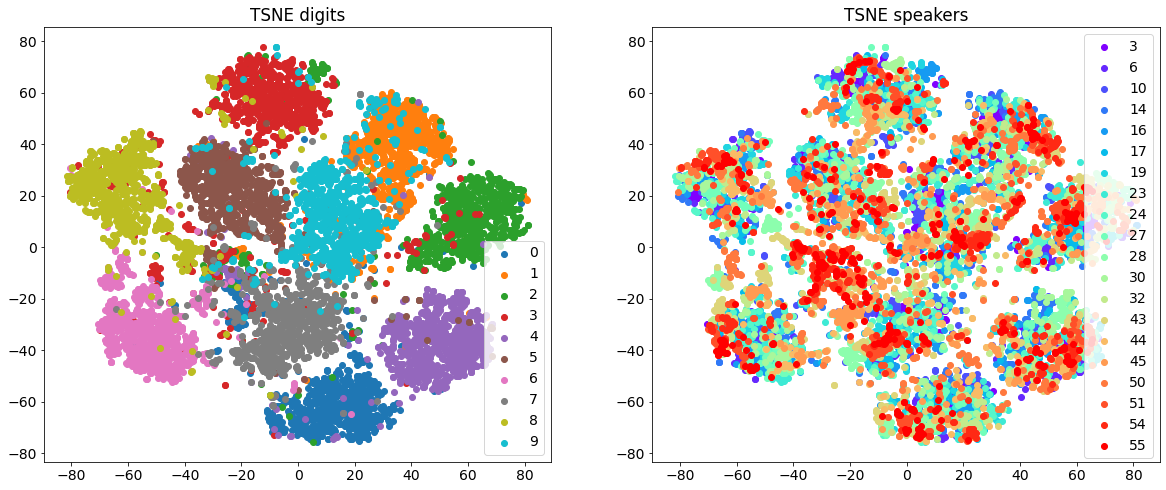

In [12]:
transforms = get_augmentations("no")
mdl = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
           hop_length=160, n_mels=80)
mdl.load_state_dict(torch.load(f"checkpoints/mfcl/no.pth"))
model = nn.Sequential(
    LogMelSpec(min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
               hop_length=160, n_mels=80),
    mdl.spec_encoder)
model.to(device)
_, _, test_dataloader = supervised.get_dataloaders(data_dir)

embeddings, speakers, digits = get_embeddings(model, test_dataloader)
draw_tsne(embeddings, speakers, digits)

### 2D encoder self-supervised

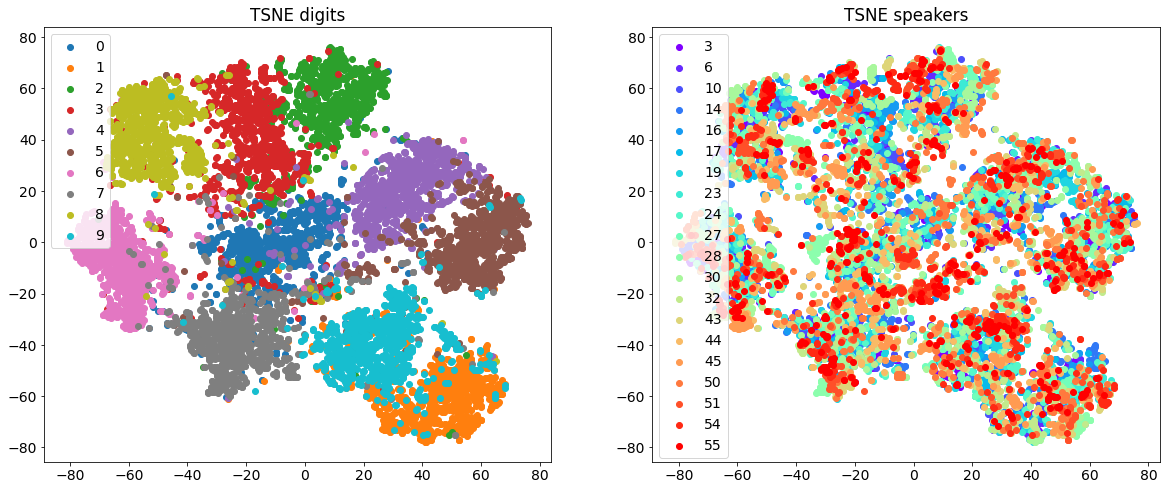

In [10]:
import supervised
from src.utils.LogMelSpec import LogMelSpec
from src.model.Encoder2D import Encoder2D
from pretrain import get_augmentations
from src.model.MFCL.MFCL import MFCL

transforms = get_augmentations("mel")
# mdl = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
#            hop_length=160, n_mels=80)
mdl = nn.Sequential(
    LogMelSpec(min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
               hop_length=160, n_mels=80),
    Encoder2D(),
    nn.Linear(512, 10)
)
mdl.load_state_dict(torch.load(f"checkpoints/2d_mel/final_model.pth"))
model = nn.Sequential(mdl[0], mdl[1])
model.to(device)
_, _, test_dataloader = supervised.get_dataloaders(data_dir)

embeddings, speakers, digits = get_embeddings(model, test_dataloader)
draw_tsne(embeddings, speakers, digits)

## KNN Speaker classification

Here we apply our pretrained models for speaker classification task. We obtain embedding of the recording using our encoders and then classify them by KNN classifier.

In [11]:
from src.data.dataset import AudioDataset
from src.utils.preprocessing import form_df

np.random.seed(SEED)
speaker_ids = np.array(os.listdir(data_dir))

test_speakers = np.random.choice(speaker_ids, int(len(speaker_ids) // 3), False)
df = form_df(test_speakers, data_dir)
groups = df.groupby(by=["speaker", "y"])
train_split = 0.5

train_ids = np.array([])
val_ids = np.array([])
for i, group in groups:
    group_train_ids, group_val_ids = np.split(group.index, [int(len(group) * train_split)])
    train_ids = np.append(train_ids, group_train_ids)
    val_ids = np.append(val_ids, group_val_ids)
train_df = df.iloc[train_ids]
val_df = df.iloc[val_ids]
train_dataset = AudioDataset(train_df)
val_dataset = AudioDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                                  collate_fn=train_dataset.collator, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                            collate_fn=val_dataset.collator, pin_memory=True, drop_last=True)

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def get_k(X, y, ks):
    res_metrics = []
    for k in ks:
        cls = KNeighborsClassifier(n_neighbors=k, metric="cosine", n_jobs=8)
        skf = StratifiedKFold(n_splits=5, random_state=322, shuffle=True)
        metrics = []
        for train_index, test_index in skf.split(X, y):
            cls.fit(X[train_index], y[train_index])
            y_pred = cls.predict(X[test_index])
            metrics.append(accuracy_score(y[test_index], y_pred))
        res_metrics.append(np.sum(metrics) / 5)
    return np.array(res_metrics)

def get_speakers_classification(X_train, y_train, X_test, ks):
    n_neighbours = get_k(X_train, y_train, ks)
    cls = KNeighborsClassifier(n_neighbors=ks[n_neighbours.argmax()], n_jobs=8)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_test)
    return y_pred

### 1D encoder supervised

In [19]:
ks = [3, 5, 10, 20, 50]

model = nn.Sequential(
    Encoder1D(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("checkpoints/1d/final_model.pth"))
model = model[0]
model.to(device)

tr_embeddings, tr_speakers, tr_digits = get_embeddings(model, train_dataloader)
tst_embeddings, tst_speakers, tst_digits = get_embeddings(model, val_dataloader)

y_pred = get_speakers_classification(tr_embeddings, tr_speakers, tst_embeddings, ks)
print("1D encoder supervised accuracy:", accuracy_score(y_pred, tst_speakers))

1D encoder supervised accuracy: 0.8629807692307693


### 1D encoder self-supervised

In [20]:
transforms = get_augmentations("no")
mdl = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
           hop_length=160, n_mels=80)
mdl.load_state_dict(torch.load(f"checkpoints/mfcl/no.pth"))
model = mdl.wav_encoder
model.to(device)

tr_embeddings, tr_speakers, tr_digits = get_embeddings(model, train_dataloader)
tst_embeddings, tst_speakers, tst_digits = get_embeddings(model, val_dataloader)

y_pred = get_speakers_classification(tr_embeddings, tr_speakers, tst_embeddings, ks)
print("1D encoder self-supervised accuracy:", accuracy_score(y_pred, tst_speakers))

1D encoder self-supervised accuracy: 0.8257211538461539


### 2D encoder supervised

In [21]:
model = nn.Sequential(
    LogMelSpec(min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
               hop_length=160, n_mels=80),
    Encoder2D(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("checkpoints/2d/final_model.pth"))
model = nn.Sequential(model[0], model[1])
model.to(device)

tr_embeddings, tr_speakers, tr_digits = get_embeddings(model, train_dataloader)
tst_embeddings, tst_speakers, tst_digits = get_embeddings(model, val_dataloader)

y_pred = get_speakers_classification(tr_embeddings, tr_speakers, tst_embeddings, ks)
print("2D encoder supervised accuracy:", accuracy_score(y_pred, tst_speakers))

2D encoder supervised accuracy: 0.19290865384615385


### 2D encoder self-supervised

In [25]:
transforms = get_augmentations("no")
mdl = MFCL(transforms, device, min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
           hop_length=160, n_mels=80)
mdl.load_state_dict(torch.load(f"checkpoints/mfcl/no.pth"))
model = nn.Sequential(
    LogMelSpec(min_eps=1e-6, max_eps=1e4, sample_rate=16_000, n_fft=400, win_length=400,
               hop_length=160, n_mels=80),
    mdl.spec_encoder)
model.to(device)

tr_embeddings, tr_speakers, tr_digits = get_embeddings(model, train_dataloader)
tst_embeddings, tst_speakers, tst_digits = get_embeddings(model, val_dataloader)

y_pred = get_speakers_classification(tr_embeddings, tr_speakers, tst_embeddings, ks)
print("2D encoder self-supervised accuracy:", accuracy_score(y_pred, tst_speakers))

2D encoder self-supervised accuracy: 0.21935096153846154
